In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from matplotlib import pyplot as plt, cm as mpl_cm
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import gseapy
import matplotlib
import matplotlib.pyplot as plt

In [4]:
sc.set_figure_params(scanpy=True, fontsize=12, dpi_save=300)

In [5]:
m1 = sc.read_10x_mtx(
    '/m1/mouse1_gex/outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    
m1.var_names_make_unique()
sc.pp.filter_cells(m1, min_genes=500)
sc.pp.filter_genes(m1, min_cells=3)
m1.var['mt'] = m1.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(m1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
m1 = m1[m1.obs.total_counts > 1000, :]
m1 = m1[m1.obs.pct_counts_mt < 10, :]
m1.obs["sample"] = "mouse1"

In [6]:
t1 = ir.io.read_10x_vdj('/m1/filtered_contig_annotations.csv')

In [7]:
ir.pp.merge_with_ir(m1, t1)

In [8]:
m2 = sc.read_10x_mtx(
    '/m2/mouse2_gex/outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    
m2.var_names_make_unique()
sc.pp.filter_cells(m2, min_genes=500)
sc.pp.filter_genes(m2, min_cells=3)
m2.var['mt'] = m2.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(m2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
m2 = m2[m2.obs.total_counts > 1000, :]
m2 = m2[m2.obs.pct_counts_mt < 10, :]
m2.obs["sample"] = "mouse2"

In [9]:
t2 = ir.io.read_10x_vdj('/m2/filtered_contig_annotations.csv')

In [10]:
ir.pp.merge_with_ir(m2, t2)

In [11]:
m = m1.concatenate(m2,fill_value=0,join='outer' )

In [12]:
sc.pp.normalize_total(m, target_sum=1e4)

In [13]:
sc.pp.log1p(m)

In [14]:
sc.pp.highly_variable_genes(m, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [15]:
m.raw = m

In [16]:
m = m[:, m.var.highly_variable]

In [17]:
sc.pp.regress_out(m, ['total_counts', 'pct_counts_mt'])

In [18]:
sc.pp.scale(m, max_value=10)

In [19]:
sc.tl.pca(m,svd_solver='arpack')

In [20]:
import bbknn

In [21]:
bbknn.bbknn(m, batch_key='sample',metric='euclidean') 

In [22]:
sc.tl.umap(m)

In [23]:
sc.tl.leiden(m,resolution=0.4)

In [ ]:
###########tcr

In [25]:
ir.tl.chain_qc(m)

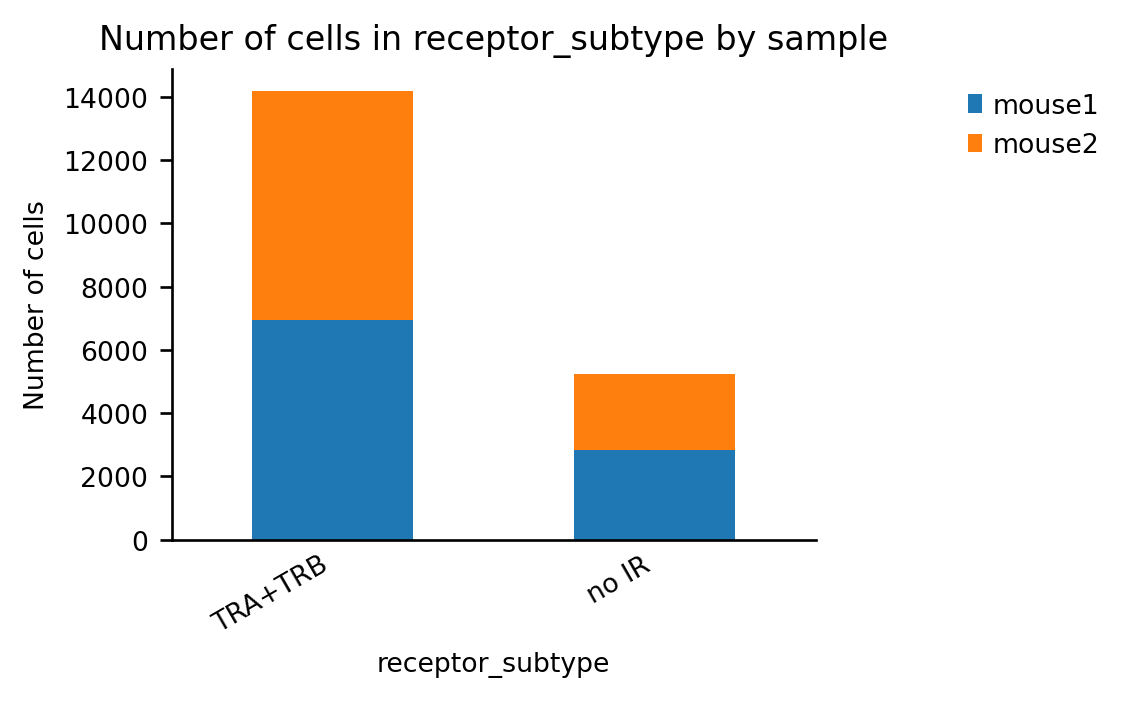

In [26]:
ax = ir.pl.group_abundance(m, groupby="receptor_subtype", target_col="sample")

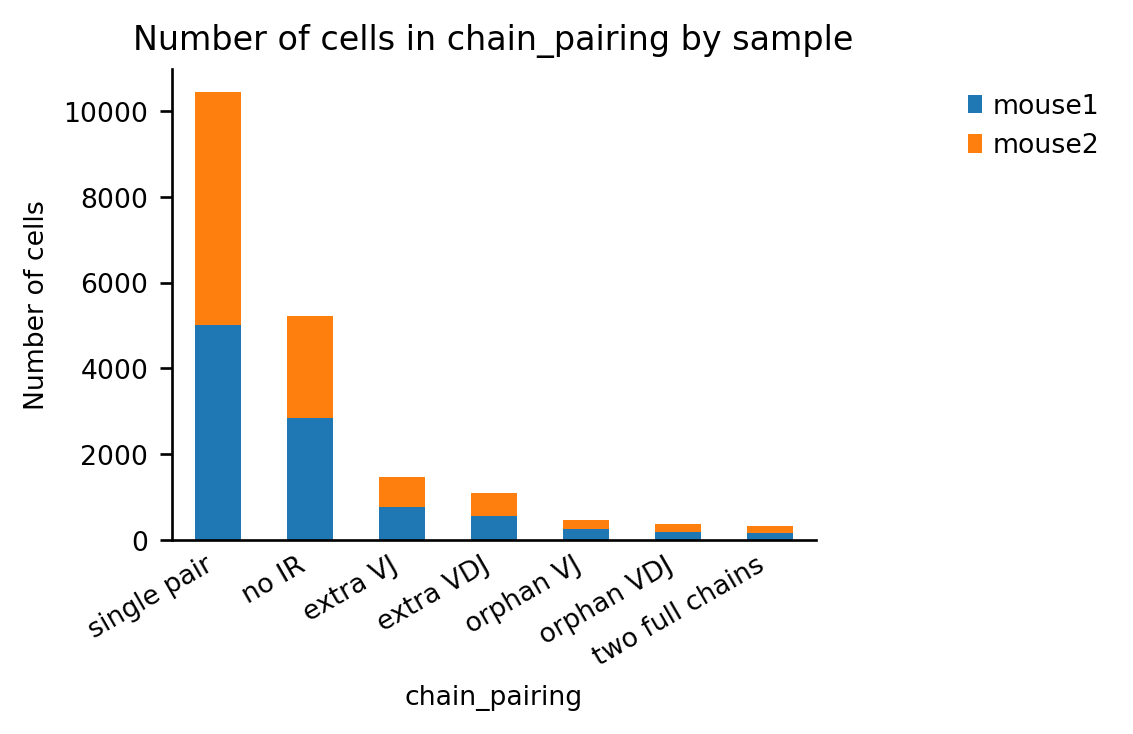

In [27]:
ax = ir.pl.group_abundance(m, groupby="chain_pairing", target_col="sample")

In [28]:
m = m[~m.obs["chain_pairing"].isin(["orphan VDJ", "orphan VJ"]), :].copy()

In [ ]:
ir.pp.ir_dist(m)
ir.tl.define_clonotypes(m, receptor_arms="all", dual_ir="primary_only")

In [ ]:
ir.tl.clonotype_network(m, min_cells=2)

In [ ]:
ir.pp.ir_dist(
    m,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)

In [ ]:
ir.tl.define_clonotype_clusters(
    m, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any"
)

In [ ]:
ir.tl.clonotype_network(m, min_cells=3, sequence="aa", metric="alignment")

In [ ]:
ir.tl.clonal_expansion(m)

In [ ]:
m_2 = m[~m.obs["chain_pairing"].isin(["no IR"]), :].copy()

In [ ]:
df=pd.crosstab(m_2.obs['leiden'],m_2.obs["IR_VDJ_1_v_call"].isin( ["TRBV26"]))
df2=df.apply(lambda r: r/r.sum(), axis=1)*100
####axis=0, sum of colum
with rc_context({'figure.figsize': (5,5)}):
    df2.plot(kind="bar", stacked=True, rot=90,label=['TRBV26-', 'TRBV26+'])
    plt.legend( bbox_to_anchor=(0.65, 1),labels=['TRBV26-', 'TRBV26+'])
    plt.ylabel("Percent",fontweight='bold')
    plt.xlabel("leiden",fontweight='bold')
    plt.grid(b=None)
    plt.savefig('fre.pdf',bbox_inches='tight')

In [ ]:
m_26=m[m.obs['IR_VDJ_1_v_call'].isin(['TRBV26']) | m.obs['IR_VDJ_2_v_call'].isin(['TRBV26'])]

In [ ]:
n_26=m[~(m.obs['IR_VDJ_1_v_call'].isin(['TRBV26']) | m.obs['IR_VDJ_2_v_call'].isin(['TRBV26']))]

In [ ]:
m_26.obs.rename(columns={"IR_VJ_1_v_call": "TRAV"}, inplace=True)
m_26.obs.rename(columns={'IR_VJ_1_j_call': "TRAJ"}, inplace=True)
m_26.obs.rename(columns={'IR_VDJ_1_v_call': "TRBV"}, inplace=True)
m_26.obs.rename(columns={'IR_VDJ_1_d_call': "TRBD"}, inplace=True)
m_26.obs.rename(columns={'IR_VDJ_1_j_call': "TRBJ"}, inplace=True)

In [ ]:
ir.io.upgrade_schema(m_26)

In [ ]:
ax=ir.pl.vdj_usage(m_26_2, full_combination=False, max_segments=None, max_ribbons=30,fig_kws={"dpi": 200},
               vdj_cols=('TRAV','TRAJ','TRBV','TRBD','TRBJ'))
plt.savefig('r26.pdf',bbox_inches='tight')

In [ ]:
n_26.obs.rename(columns={"IR_VJ_1_v_call": "TRAV"}, inplace=True)
n_26.obs.rename(columns={'IR_VJ_1_j_call': "TRAJ"}, inplace=True)
n_26.obs.rename(columns={'IR_VDJ_1_v_call': "TRBV"}, inplace=True)
n_26.obs.rename(columns={'IR_VDJ_1_d_call': "TRBD"}, inplace=True)
n_26.obs.rename(columns={'IR_VDJ_1_j_call': "TRBJ"}, inplace=True)

In [ ]:
ir.io.upgrade_schema(n_26)

In [ ]:
ax=ir.pl.vdj_usage(n_26, full_combination=False, max_segments=None, max_ribbons=30,fig_kws={"dpi": 200},
                  vdj_cols=('TRAV','TRAJ','TRBV','TRBD','TRBJ'))
plt.savefig('rn26.pdf',bbox_inches='tight')

In [ ]:
##############trajectory 

In [ ]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

In [ ]:
sc.pp.neighbors(m, n_neighbors=4, n_pcs=20)

In [ ]:
sc.tl.draw_graph(m)

In [ ]:
sc.pl.draw_graph(m, color='celltype', legend_loc='on data')

In [ ]:
m_1 = scv.read('/m1/m1_gex_out.loom', cache=True)

In [ ]:
barcode_m_1 = [bc.split(':')[1] for bc in m_1.obs.index.tolist()]
barcode_m_1_2 = [bc[0:len(bc)-1] + '-1-0' for bc in barcode_m_1]
m_1.obs.index = barcode_m_1_2
m_1.var_names_make_unique()
m_1.obs.index

In [ ]:
m_2 = scv.read('/m2/m2_gex_out.loom', cache=True)

In [ ]:
barcode_m_2 = [bc.split(':')[1] for bc in m_2.obs.index.tolist()]
barcode_m_2_2 = [bc[0:len(bc)-1] + '-1-1' for bc in barcode_m_2]
m_2.obs.index = barcode_m_2_2
m_2.var_names_make_unique()
m_2.obs.index

In [ ]:
m_loom = m_1.concatenate([m_2])

In [ ]:
m = scv.utils.merge(m, m_loom)

In [ ]:
scv.pl.proportions(m)

In [ ]:
scv.pp.filter_and_normalize(m, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(m)
sc.pp.neighbors(m, n_pcs=30, n_neighbors=30)
scv.pp.moments(m, n_pcs=None, n_neighbors=None)

In [ ]:
scv.tl.recover_dynamics(m)

In [ ]:
scv.tl.velocity(m, mode="dynamical")
scv.tl.velocity_graph(m)

In [ ]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo',dpi=80, dpi_save=300,figsize=[4, 4]) 

In [ ]:
scv.pl.velocity_embedding_stream(
    m, basis="umap", legend_fontsize=12, title="", smooth=0.8, min_mass=4, color="leiden"
)

In [ ]:
scv.pl.velocity_embedding_stream(
    m, basis="draw_graph_fa", legend_fontsize=12, title="", smooth=0.8, min_mass=4, color="leiden", save='rna.pdf'
)